In [68]:
# shadril238
# Forcasting

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os

# For preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

# For models
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# For evaluation
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

# For mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load configuration


In [85]:
# Participant to forecast
USER = 'participant1'

# Collection dataset
# COLLECTION = '2-person'
COLLECTION = '10-person'

# Define train data path
TRAIN_DATA_PATH = f'/content/drive/MyDrive/ML DL/ABC2023/ABC2023-WearingOffChallenge/pd_train_dataset/{COLLECTION}'

# Define test data path
TEST_DATA_PATH = f'/content/drive/MyDrive/ML DL/ABC2023/ABC2023-WearingOffChallenge/pd_test_dataset'

# To check if the TRAIN_DATA_PATH exists
if os.path.exists(TRAIN_DATA_PATH):
    print('TRAIN_DATA_PATH exists!')
else:
    print('TRAIN_DATA_PATH does not exist!')

# To check if the TEST_DATA_PATH exists
if os.path.exists(TEST_DATA_PATH):
    print('TEST_DATA_PATH exists!')
else:
    print('TEST_DATA_PATH does not exist!')


TRAIN_DATA_PATH exists!
TEST_DATA_PATH exists!


In [86]:
# Choose features

# Garmin features Garmin
features = ['heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem',
            'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# Additional features
features += ['timestamp_hour', 'timestamp_dayofweek',
             'timestamp_hour_sin', 'timestamp_hour_cos']

TARGET_COLUMN = 'wearing_off'
features.append(TARGET_COLUMN)

columns = ['timestamp'] + features + ['participant']

# Normalize features
normalize_features = features

# Metrics & Other Hyperparameters
SHIFT = 1
N_IN = 2   # t-2, t-1, t
N_OUT = 2  # t+1
RECORD_SIZE_PER_DAY = 96  # 60 minutes / 15 minutes * 24 hours = 96
FIGSIZE = (20, 7)
FIGSIZE_CM = (13, 7)

In [87]:
# Define test periods
test_horizons = {
  "participant1": ["2021-12-02 0:00", "2021-12-03 23:45"],
  "participant2": ["2021-11-28 0:00", "2021-11-29 23:45"],
  "participant3": ["2021-11-25 0:00", "2021-11-26 23:45"],
  "participant4": ["2021-12-06 0:00", "2021-12-07 7:15"],
  "participant5": ["2021-11-28 0:00", "2021-11-29 23:45"],
  "participant6": ["2021-12-06 0:00", "2021-12-07 23:45"],
  "participant7": ["2021-12-12 0:00", "2021-12-13 9:45"],
  "participant8": ["2021-12-23 0:00", "2021-12-24 23:45"],
  "participant9": ["2021-12-23 0:00", "2021-12-24 23:45"],
  "participant10": ["2021-12-23 0:00", "2021-12-24 23:45"],
}

# Convert test periods to DataFrame
test_horizons_df = pd.DataFrame(
  [[participant, test_start_date, test_end_date]
   for participant, (test_start_date, test_end_date) in test_horizons.items()],
  columns=['participant', 'test_start_date', 'test_end_date']
)

In [88]:
# Load participant's Excel file TRAIN SET
dataset = pd.read_excel(f'{TRAIN_DATA_PATH}/combined_data.xlsx',
                        index_col="timestamp",
                        usecols=columns,
                        engine='openpyxl').query(f'participant == "{USER}"')

# Fill missing data with 0
dataset.fillna(0, inplace=True)

# Filter by participant
dataset = dataset.query(f'participant == "{USER}"').drop(
    columns=['participant'])

# -----------------------------------------------------------------------------
# Load participant's Excel file TEST SET
dataset_test = pd.read_excel(f'{TEST_DATA_PATH}/combined_data.xlsx',
                             index_col="timestamp",
                             usecols=columns,
                             engine='openpyxl').query(f'participant == "{USER}"')

# Fill missing data with 0
dataset_test.fillna(0, inplace=True)

# Filter by participant
dataset_test = dataset_test.query(f'participant == "{USER}"').drop(
    columns=['participant'])

In [89]:
# Re-assign for convenience
train_df = dataset.copy()
test_df = dataset_test.copy()

In [90]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  var_names = data.columns
  n_vars = len(var_names)
  df = pd.DataFrame(data)
  cols, names = list(), list()  # new column values, new columne names

  # input sequence (t-i, ... t-1)
  #   timesteps before (e.g., n_in = 3, t-3, t-2, t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += list(
        map(lambda var_name: f'{var_name}(t-{i})', var_names)
    )

  # forecast sequence (t, t+1, ... t+n)
  #   timesteps after (e.g., n_out = 3, t, t+1, t+2)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += list(map(lambda var_name: f'{var_name}(t)', var_names))
    else:
      names += list(map(lambda var_name: f'{var_name}(t+{i})', var_names))

  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names

  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)

  return agg

In [91]:
# Split into X and y

def split_x_y(df, target_columns, SHIFT=SHIFT, drop_wearing_off=True):
  # Drop extra columns i.e., (t+1), (t+2), (t+3), (t+4)
  regex = r".*\(t\+[1-{SHIFT}]\)$"  # includes data(t)
  # regex = r"\(t(\+([1-{SHIFT}]))?\)$" # removes data(t)

  # Drop extra columns except target_columns
  df.drop(
    [x for x in df.columns if re.search(regex, x) and x not in target_columns],
    axis=1, inplace=True
  )

  # Split into X and y
  y = df[target_columns].copy()
  X = df.drop(target_columns + [f'{TARGET_COLUMN}(t)'], axis=1)

  if drop_wearing_off:
    # Delete past wearing_off data, because it will not be provided in test data.
    #   Predicted past weaering_off can be used as feature, but make it yourself.
    wearing_off_features = X.filter(like='wearing_off').columns
    X = X.drop(columns=wearing_off_features)

  return (X, y)

In [92]:
# Load submission file to get test data times
submission_df = pd.read_csv(f'{TEST_DATA_PATH}/submission.csv',
                            index_col=0
                            ).query(f'participant == "{USER}"')
submission_df['Timestamp'] = pd.to_datetime(submission_df['Timestamp'])
submission_df['reframed_timestamp'] = pd.to_datetime(
  submission_df['reframed_timestamp']
)
submission_df.rename(columns={'Timestamp': 'timestamp'}, inplace=True)


def keep_forecast_times(full_test_data, submission_df):
  # Keep the test data times
  #   with the same participant & timestamp
  return full_test_data.reset_index().merge(
    submission_df[['reframed_timestamp']],
    left_on=['timestamp'],
    right_on=['reframed_timestamp'],
    how='right'
  ).drop(columns='reframed_timestamp').set_index('timestamp')

In [93]:
# TRAIN SET
# n_in = 2 i.e., 30 minutes before (t-2, t-1, t)
# n_out = 2 i.e., 15 minutes after (t+1)
# Example:
#   t = 00:45:00
#   X = { 00:15:00, 00:30:00, 00:45:00 }
#   y = { 1:00:00 }

reframed_train_df = series_to_supervised(train_df,
                                         n_in=N_IN,
                                         n_out=N_OUT,
                                         dropnan=True)

train_X, train_y = split_x_y(
    reframed_train_df, [f'{TARGET_COLUMN}(t+{N_OUT-1})'])

display(train_y.head(5))
display(train_X.head(5))

,wearing_off(t+1)
timestamp,
2021-11-25 00:30:00,0.0
2021-11-25 00:45:00,0.0
2021-11-25 01:00:00,0.0
2021-11-25 01:15:00,0.0
2021-11-25 01:30:00,0.0


,heart_rate(t-2),steps(t-2),stress_score(t-2),awake(t-2),deep(t-2),light(t-2),rem(t-2),nonrem_total(t-2),total(t-2),nonrem_percentage(t-2),...,light(t),rem(t),nonrem_total(t),total(t),nonrem_percentage(t),sleep_efficiency(t),timestamp_hour(t),timestamp_dayofweek(t),timestamp_hour_sin(t),timestamp_hour_cos(t)
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-11-25 00:30:00,0.000000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0.130526,0.991445
2021-11-25 00:45:00,0.000000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0.195090,0.980785
2021-11-25 01:00:00,43.419355,0.0,-0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,3,0.258819,0.965926
2021-11-25 01:15:00,60.250000,0.0,12.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,3,0.321439,0.946930
2021-11-25 01:30:00,10.600000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,3,0.382683,0.923880


In [94]:
# TEST SET
# n_in = 2 i.e., 30 minutes before (t-2, t-1, t)
# n_out = 2 i.e., 15 minutes after (t+1)
# Example:
#   t = 00:45:00
#   X = { 00:15:00, 00:30:00, 00:45:00 }
#   y = { 1:00:00 }

reframed_test_df = series_to_supervised(test_df,
                                        n_in=N_IN,
                                        n_out=N_OUT,
                                        dropnan=True)


# Keep only the test data times based on submission file
tmp_df = keep_forecast_times(reframed_test_df,
                             submission_df=submission_df)

test_X, test_y = split_x_y(tmp_df, [f'{TARGET_COLUMN}(t+{N_OUT-1})'])

display(test_y.head(10))
display(test_X.head(10))

,wearing_off(t+1)
timestamp,
2021-12-02 00:45:00,0.0
2021-12-02 00:45:00,0.0
2021-12-02 00:45:00,0.0
2021-12-02 01:45:00,0.0
2021-12-02 01:45:00,0.0
2021-12-02 01:45:00,0.0
2021-12-02 02:45:00,0.0
2021-12-02 02:45:00,0.0
2021-12-02 02:45:00,0.0


,heart_rate(t-2),steps(t-2),stress_score(t-2),awake(t-2),deep(t-2),light(t-2),rem(t-2),nonrem_total(t-2),total(t-2),nonrem_percentage(t-2),...,light(t),rem(t),nonrem_total(t),total(t),nonrem_percentage(t),sleep_efficiency(t),timestamp_hour(t),timestamp_dayofweek(t),timestamp_hour_sin(t),timestamp_hour_cos(t)
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-02 00:45:00,-1.000000,0.0,-1.0,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,0,3,0.195090,0.980785
2021-12-02 00:45:00,-1.000000,0.0,-1.0,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,0,3,0.195090,0.980785
2021-12-02 00:45:00,-1.000000,0.0,-1.0,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,0,3,0.195090,0.980785
2021-12-02 01:45:00,19.133333,15.0,7.4,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,1,3,0.442289,0.896873
2021-12-02 01:45:00,19.133333,15.0,7.4,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,1,3,0.442289,0.896873
2021-12-02 01:45:00,19.133333,15.0,7.4,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,1,3,0.442289,0.896873
2021-12-02 02:45:00,69.800000,0.0,3.6,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,2,3,0.659346,0.751840
2021-12-02 02:45:00,69.800000,0.0,3.6,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,2,3,0.659346,0.751840
2021-12-02 02:45:00,69.800000,0.0,3.6,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,2,3,0.659346,0.751840


In [95]:
# MinMaxScaler was used but feel free to change
scaler = MinMaxScaler(feature_range=(0, 1))

# TRAIN SET
train_X_scaled = scaler.fit_transform(train_X)
train_X_scaled = pd.DataFrame(train_X_scaled,
                              columns=train_X.columns,
                              index=train_X.index)

# TEST SET
test_X_scaled = scaler.fit_transform(test_X)
test_X_scaled = pd.DataFrame(test_X_scaled,
                             columns=test_X.columns,
                             index=test_X.index)

In [96]:
# Normalizer was used but feel free to change
normalizer = Normalizer()

# TRAIN SET
train_X_scaled_normalized = normalizer.fit_transform(train_X_scaled)
train_X_scaled_normalized = pd.DataFrame(train_X_scaled_normalized,
                                         columns=train_X.columns,
                                         index=train_X.index)

# TEST SET
test_X_scaled_normalized = normalizer.fit_transform(test_X_scaled)
test_X_scaled_normalized = pd.DataFrame(test_X_scaled_normalized,
                                        columns=test_X.columns,
                                        index=test_X.index)

In [97]:
# Keep original processed data for later use
original_train_X_scaled_normalized = train_X_scaled_normalized.copy()
original_train_X = train_X.copy()
original_train_y = train_y.copy()
original_test_X = test_X.copy()

In [98]:
# Split train set to train and validation set for participant's internal validation
train_X, val_X, train_y, val_y = train_test_split(original_train_X_scaled_normalized,
                                                  original_train_y,
                                                  test_size=0.33,
                                                  random_state=4)
test_X = test_X_scaled_normalized.copy()

In [99]:
# create model instance
xgb_model = XGBClassifier(random_state=4, n_estimators=1000)

# fit model
xgb_model.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=4, ...)

In [100]:
# Make forecasts for validation set
forecasts = xgb_model.predict(
  val_X
)

# Get the probability for 1s class
forecasts_proba = xgb_model.predict_proba(
  val_X
)[:, 1]

# Transform as dataframe with timestamp
forecasts_output = pd.DataFrame(
  {
    'participant': [USER] * len(forecasts),
    'forecasted_wearing_off': forecasts,
    'forecasted_wearing_off_probability': forecasts_proba,
    'ground_truth': val_y.values.flatten(),
  },
  index=val_X.index
)

# Sort by timestamp
forecasts_output.sort_index(inplace=True)

In [101]:
# Make forecasts for test set and submission
forecasts_test = xgb_model.predict(
  test_X
)

# Get the probability for 1s class
forecasts_proba_test = xgb_model.predict_proba(
  test_X
)[:, 1]

# Transform as dataframe with timestamp
forecasts_output_test = pd.DataFrame(
  {
    'participant': [USER] * len(forecasts_test),
    'forecasted_wearing_off': forecasts_test,
    'forecasted_wearing_off_probability': forecasts_proba_test,
    'ground_truth': test_y.values.flatten(),
  },
  index=test_X.index
)

# Sort by timestamp
forecasts_output_test.sort_index(inplace=True)

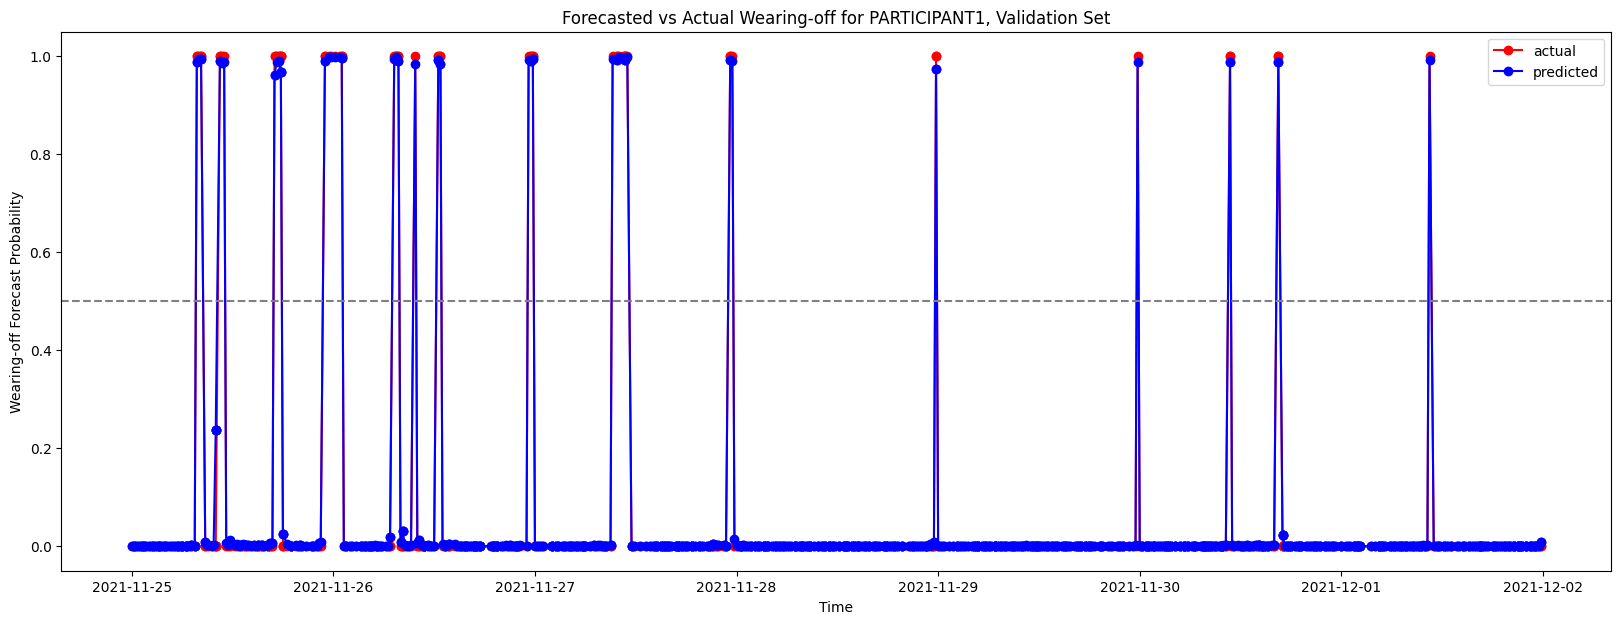

In [102]:
# Plot Actual vs Forcast
# For Validation Set

# Plot ground truth, & predicted probability on the same plot to show the difference
plt.figure(figsize=FIGSIZE)
plt.plot(forecasts_output.ground_truth,
         label='actual', color='red', marker='o',)
plt.plot(forecasts_output.forecasted_wearing_off_probability,
         label='predicted', color='blue', marker='o')
# plt.plot(forecasts_output.forecasted_wearing_off,
#          label='predicted', color='blue', marker='o')
plt.legend()

# Dashed horizontal line at 0.5
plt.axhline(0.5, linestyle='--', color='gray')

# Set y-axis label
plt.ylabel('Wearing-off Forecast Probability')

# Set x-axis label
plt.xlabel('Time')

# Set title
plt.title(
    f"Forecasted vs Actual Wearing-off for {USER.upper()}, Validation Set")

plt.show()

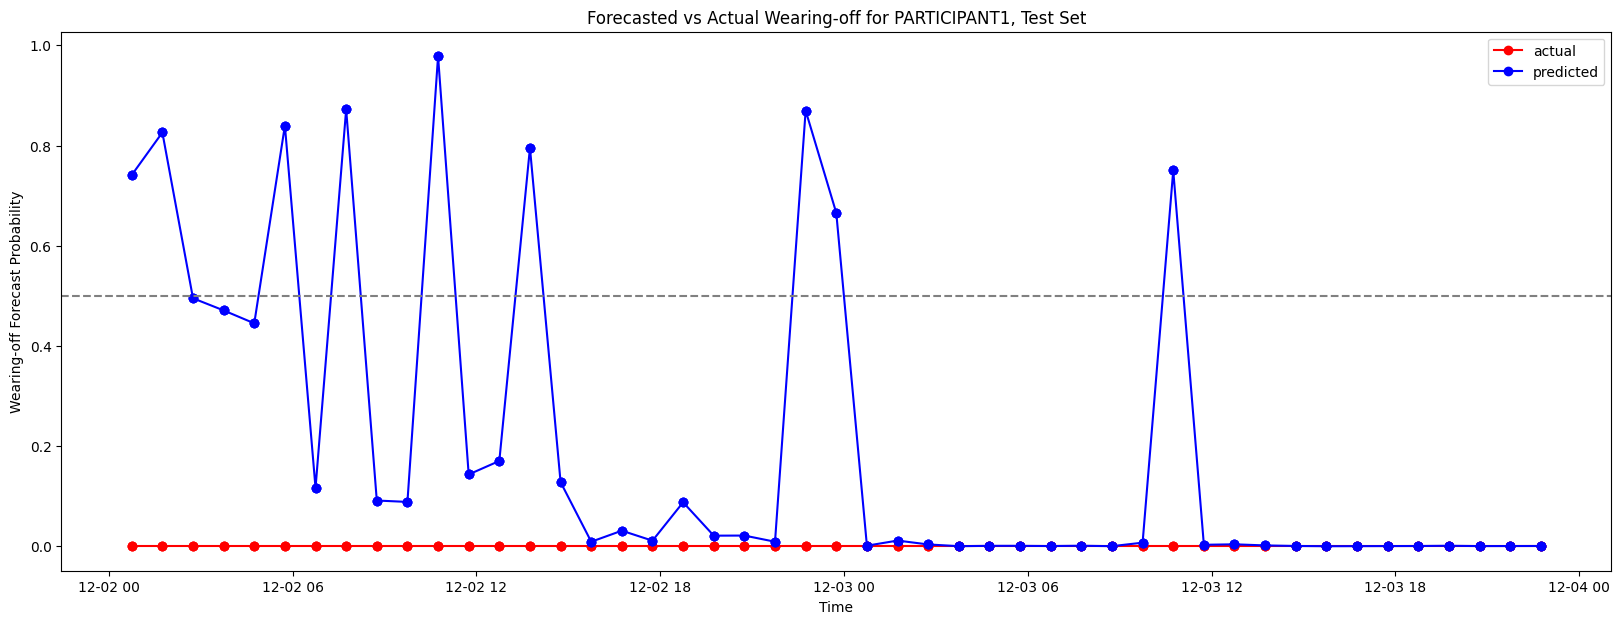

In [103]:
# For Test Set

# Plot ground truth, & predicted probability on the same plot to show the difference
plt.figure(figsize=FIGSIZE)
plt.plot(forecasts_output_test.ground_truth,
         label='actual', color='red', marker='o',)
plt.plot(forecasts_output_test.forecasted_wearing_off_probability,
         label='predicted', color='blue', marker='o')
# plt.plot(forecasts_output_test.forecasted_wearing_off,
#          label='predicted', color='blue', marker='o')
plt.legend()

# Dashed horizontal line at 0.5
plt.axhline(0.5, linestyle='--', color='gray')

# Dashed vertical lines on each hour
for i in forecasts_output_test.index:
  if pd.Timestamp(i).minute == 0:
    plt.axvline(i, linestyle='--', color='gray')

# Set y-axis label
plt.ylabel('Wearing-off Forecast Probability')

# Set x-axis label
plt.xlabel('Time')

# Set title
plt.title(f"Forecasted vs Actual Wearing-off for {USER.upper()}, Test Set")

plt.show()

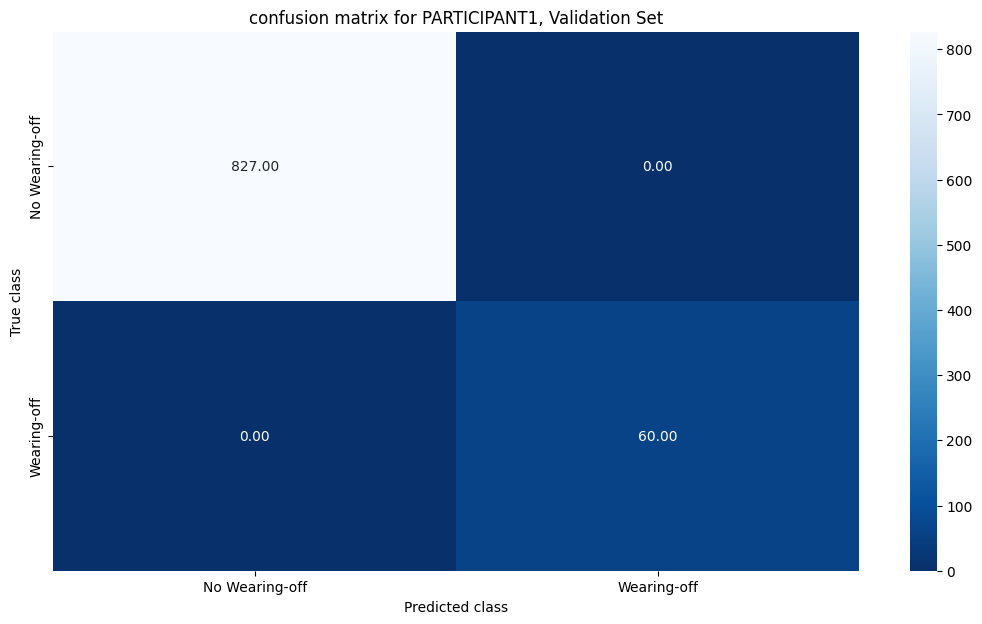

In [104]:
# Plot confusion matrix for each participant

# Set labels for confusion matrix
labels = ['No Wearing-off', 'Wearing-off']

# Calculate confusion matrix
conf_matrix = confusion_matrix(forecasts_output.ground_truth,
                               forecasts_output.forecasted_wearing_off)
# Plot confusion matrix
plt.figure(figsize=FIGSIZE_CM)
sns.heatmap(conf_matrix,
            xticklabels=labels, yticklabels=labels,
            annot=True, fmt=".2f", cmap='Blues_r')

# Set y-axis label
plt.ylabel('True class')

# Set x-axis label
plt.xlabel('Predicted class')

# Set title
plt.title(f"confusion matrix for {USER.upper()}, Validation Set")

plt.show()

In [105]:
# Calculate fpr, tpr, thresholds
fpr, tpr, thresholds = metrics.roc_curve(forecasts_output.sort_index().ground_truth,
                                         forecasts_output.sort_index().forecasted_wearing_off_probability)

######################
# Evaluate predictions with f1 score, recall, precision, accuracy, auc-roc, auc-prc
model_metric_scores = pd.DataFrame(
  [
    metrics.f1_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.recall_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.precision_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.accuracy_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.auc(fpr, tpr),
    metrics.average_precision_score(
      forecasts_output.sort_index().ground_truth,
      forecasts_output.sort_index().forecasted_wearing_off_probability)
  ],
  index=['f1 score', 'recall', 'precision', 'accuracy', 'auc-roc', 'auc-prc'],
  columns=['metrics']
).T.round(3).assign(participant=USER)
model_metric_scores.set_index(['participant'], inplace=True)

######################
# Generate classification report
model_classification_report = pd.DataFrame(
  classification_report(
    forecasts_output.ground_truth,
    forecasts_output.forecasted_wearing_off,
    output_dict=True
  )
).T.round(3).assign(participant=USER)
# Set index's name to 'classification report'
model_classification_report.index.name = 'classification report'

# Remove row that has 'accuracy' as index
model_classification_report = model_classification_report.drop(
  ['accuracy'], axis=0)

model_classification_report = model_classification_report.reset_index()
model_classification_report.set_index(
    ['participant', 'classification report'], inplace=True)

model_metric_scores.reset_index(inplace=True)
model_classification_report.reset_index(inplace=True)

display(model_metric_scores)
display(model_classification_report)

,participant,f1 score,recall,precision,accuracy,auc-roc,auc-prc
0,participant1,1.0,1.0,1.0,1.0,1.0,1.0


,participant,classification report,precision,recall,f1-score,support
0,participant1,0.0,1.0,1.0,1.0,827.0
1,participant1,1.0,1.0,1.0,1.0,60.0
2,participant1,macro avg,1.0,1.0,1.0,887.0
3,participant1,weighted avg,1.0,1.0,1.0,887.0


In [106]:
# Load submission file as template

template_df = pd.read_csv(f'{TEST_DATA_PATH}/submission.csv', index_col=0)
template_df['Timestamp'] = pd.to_datetime(template_df['Timestamp'])
template_df['reframed_timestamp'] = pd.to_datetime(
    template_df['reframed_timestamp'])
template_df.head(5)

,Timestamp,reframed_timestamp,participant,final_wearing_off
0,2021-12-02 01:00:00,2021-12-02 00:45:00,participant1,NaN
1,2021-12-02 02:00:00,2021-12-02 01:45:00,participant1,NaN
2,2021-12-02 03:00:00,2021-12-02 02:45:00,participant1,NaN
3,2021-12-02 04:00:00,2021-12-02 03:45:00,participant1,NaN
4,2021-12-02 05:00:00,2021-12-02 04:45:00,participant1,NaN


In [107]:
# Merge template with forecasts_output_test

output_df = template_df.merge(
  forecasts_output_test.reset_index(),
  left_on=['reframed_timestamp', 'participant'],
  right_on=['timestamp', 'participant']
)[
  list(template_df.columns)[:-1] + ['forecasted_wearing_off']
].rename(
  columns={'forecasted_wearing_off': 'final_wearing_off'}
)
output_df.head(5)

,Timestamp,reframed_timestamp,participant,final_wearing_off
0,2021-12-02 01:00:00,2021-12-02 00:45:00,participant1,1
1,2021-12-02 01:00:00,2021-12-02 00:45:00,participant1,1
2,2021-12-02 01:00:00,2021-12-02 00:45:00,participant1,1
3,2021-12-02 02:00:00,2021-12-02 01:45:00,participant1,1
4,2021-12-02 02:00:00,2021-12-02 01:45:00,participant1,1


In [108]:
# Save submission file

# Specify teamname
teamname = 'AIUB_Data_Detectives'
for_saving_file =  f'/content/drive/MyDrive/ML DL/ABC2023/ABC2023-WearingOffChallenge/submission_{teamname}.csv'

# Delete submission file if needed
# os.remove(for_saving_file)

# Compile all participants into one submission file
if os.path.exists(for_saving_file):
  # Append csv
  output_df.to_csv(for_saving_file, index=True, mode='a', header=False)
else:
  # Create csv
  output_df.to_csv(for_saving_file, index=True)